In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
GRAVITY = 9.81
NUM_COLUMNS = int(2**9 * (17* (1-(1/2))+(1/2))) #4608  #how to know what input num here will prodcuce a segment size that is a power of 2
PERCENT_SHOWN = .1 #Percentage of data shown in graphs
SAMPLING_FREQUENCY = 4 #4 Hz -> 4 samples a second
NDBC_BANDWIDTHS = [0.010] + [0.005 for i in range(13)] + [0.010 for i in range(26)] + [0.020 for i in range(7)]

#### construct the time signal

In [3]:
time_interval = 1 / SAMPLING_FREQUENCY #number of seconds for each sample
signal_frequency = .2 #frequency of signal -> number of cycles completed in 1 second 
number_of_samples_per_cycle = int(SAMPLING_FREQUENCY / signal_frequency) #Number of samples per cycle
t = np.linspace(0,(NUM_COLUMNS-1)*time_interval, NUM_COLUMNS) #time stamps of signal
y = 1 * np.sin(2 * np.pi * signal_frequency * t)

print(f"There are {number_of_samples_per_cycle} samples per cycle")
print(f"This means there will be {NUM_COLUMNS/number_of_samples_per_cycle} cycles in the time series")

#add a linear increase to test deterending method
increase = .001
for index in range(len(y)):
    y[index]+= increase * index 

#add some outliers 
y[15] = 3.1
y[100] = -2.9

There are 20 samples per cycle
This means there will be 230.4 cycles in the time series


In [4]:
data_shown = int(len(y) * PERCENT_SHOWN)

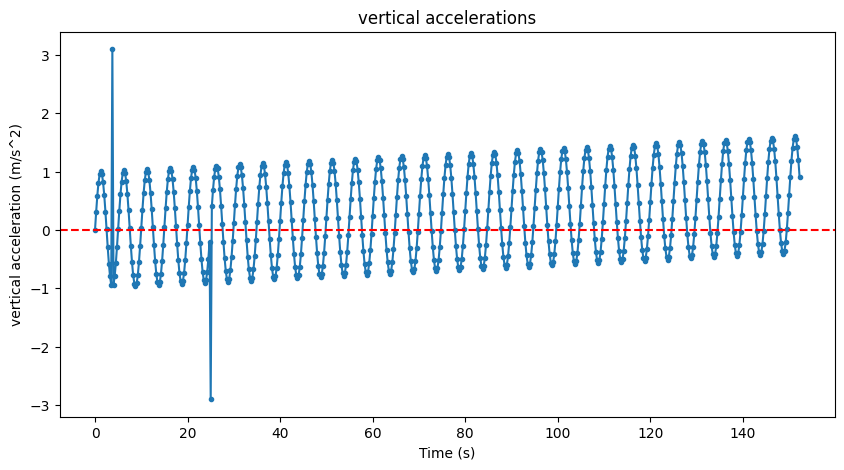

In [5]:
#plt.plot()
plt.figure(figsize=(10,5)) 
plt.plot(t[0:data_shown+150],y[0:data_shown+150], '.-')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('vertical accelerations')
plt.xlabel('Time (s)')
plt.ylabel('vertical acceleration (m/s^2)')
plt.show()

#### linearly detrend the vertical accelerations

In [6]:
sumX, sumY, sumXY, sumXX = 0,0,0,0

for i in range(0,NUM_COLUMNS):
    sumX += i+1;
    sumY += y[i]    
    sumXY += (i+1) * y[i] 
    sumXX += (i+1) * (i+1)
    
slope = (NUM_COLUMNS * sumXY - sumX * sumY) / (NUM_COLUMNS * sumXX - sumX * sumX)
intercept = (sumY - slope * sumX) / NUM_COLUMNS

for i in range(0,NUM_COLUMNS):
    y[i] -= (slope * (i+1) + intercept)

In [7]:
mean = np.mean(y)
std_dev = np.std(y)

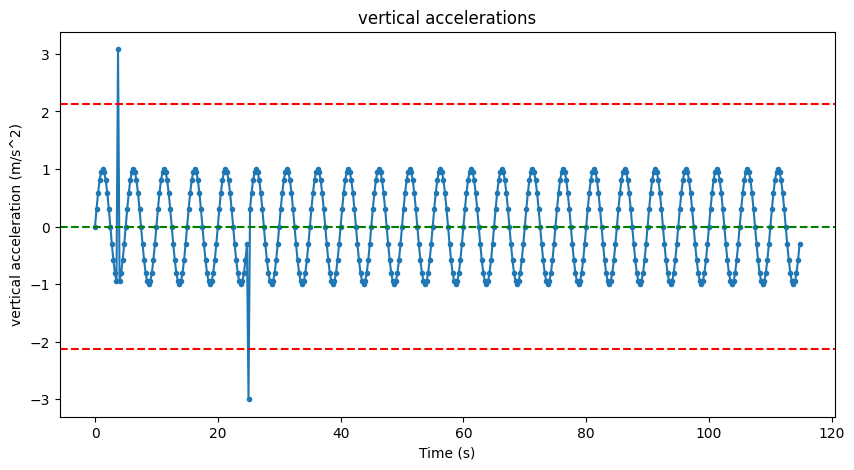

In [8]:
plt.figure(figsize=(10,5)) 
plt.plot(t[0:data_shown],y[0:data_shown], '.-')
plt.axhline(y=mean, color='green', linestyle='--')
plt.axhline(y=(mean+3*std_dev), color='red', linestyle='--')
plt.axhline(y=(mean-3*std_dev), color='red', linestyle='--')
plt.title('vertical accelerations')
plt.xlabel('Time (s)')
plt.ylabel('vertical acceleration (m/s^2)')
plt.show()

#### Remove and interpolate outliers 

In [9]:
from scipy.interpolate import CubicSpline
# Convert the list to a NumPy array for easier manipulation
y = np.array(y)

# Identify outlier indices
outlier_indices = np.where(np.abs(y - mean) > 3 * std_dev)[0]    

# Create valid indices
valid_indices = np.arange(len(y))
valid_indices = np.delete(valid_indices, outlier_indices)
        
#Sort the valid indices
valid_indices_sorted = np.sort(valid_indices)

# Perform cubic spline interpolation on valid data
cs = CubicSpline(valid_indices_sorted, y[valid_indices_sorted])

# Interpolate missing values                     
interpolated_values = cs(outlier_indices)

print(interpolated_values)

# Replace interpolated values in the original list
for i, index in enumerate(outlier_indices):
    y[index] = interpolated_values[i]

[-1.00207836 -0.00270698]


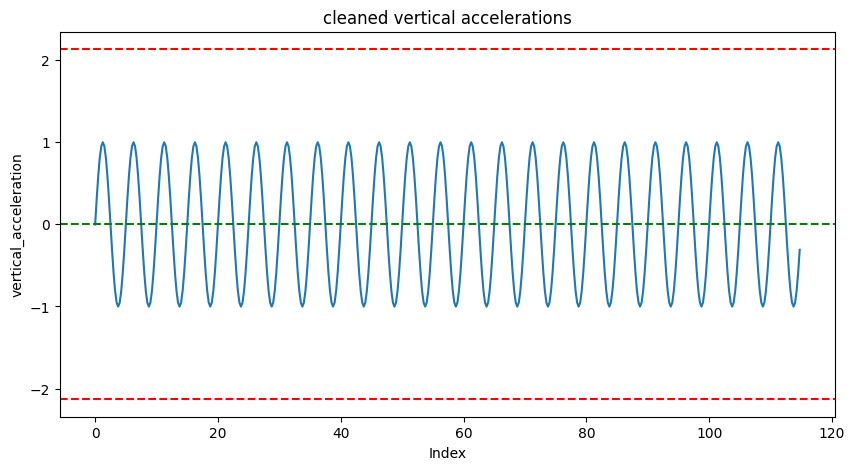

In [10]:
plt.figure(figsize=(10,5)) 

plt.plot(t[0:data_shown],y[0:data_shown])

# Set the plot title and axis labels
plt.title('cleaned vertical accelerations')
plt.xlabel('Index')
plt.ylabel('vertical_acceleration')

plt.axhline(y=mean, color='green', linestyle='--')
plt.axhline(y=(mean+3*std_dev), color='red', linestyle='--')
plt.axhline(y=(mean-3*std_dev), color='red', linestyle='--')

# Show the plot
plt.show()

#### Break data into segments

In [11]:

overlapPercent = 0.5
nonOverlapPercent = 1-overlapPercent
N_Segments = 17

nonOverlapSize = int(len(y) // (N_Segments + overlapPercent / nonOverlapPercent))
overlapSize = int(overlapPercent * nonOverlapSize / nonOverlapPercent)
#segmentSize = overlapSize + nonOverlapSize

segmentSize = int(nonOverlapSize * (1+overlapPercent/(1-overlapPercent)))

print("overlap size", overlapSize)
print("non-overlap size", nonOverlapSize)
print("segment size", segmentSize)

segments = []
for i in range(0, len(y), nonOverlapSize):
    if i+segmentSize <= len(y):
        segments.append(y[i:i+segmentSize])

print("Segments count", len(segments))
print(list(map(len, segments)))

overlap size 256
non-overlap size 256
segment size 512
Segments count 17
[512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512]


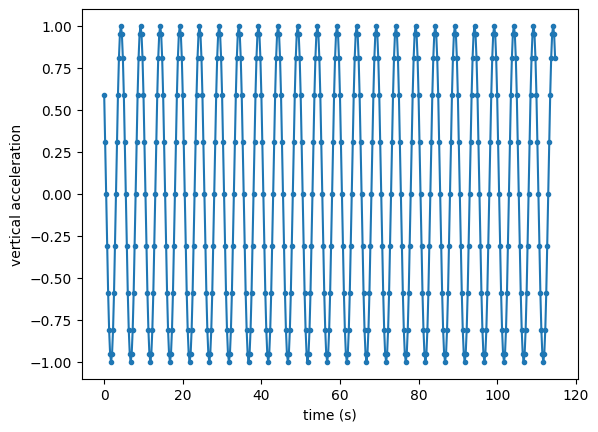

In [12]:
plt.plot()
#plt.plot(segments, '.-')
plt.plot(t[0:data_shown],segments[3][0:data_shown], '.-')

plt.xlabel("time (s)")
plt.ylabel("vertical acceleration")
plt.show()

#### Apply Kaiser-Bessel Window

In [13]:
from scipy import signal

BETA = .5
SEGMENT_SIZE = len(segments[0])

window = signal.windows.kaiser(SEGMENT_SIZE, beta = BETA, sym = True)
appliedSegments = list(map(lambda segment: segment * window, segments))

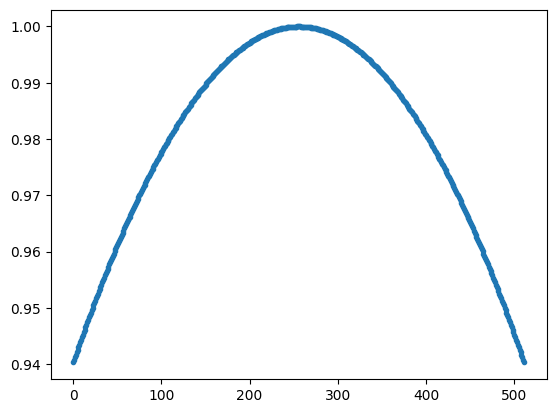

In [14]:
plt.plot()
plt.plot(window, '.-')

#plt.xlabel("time (s)")
#plt.ylabel("vertical acceleration")
plt.show()

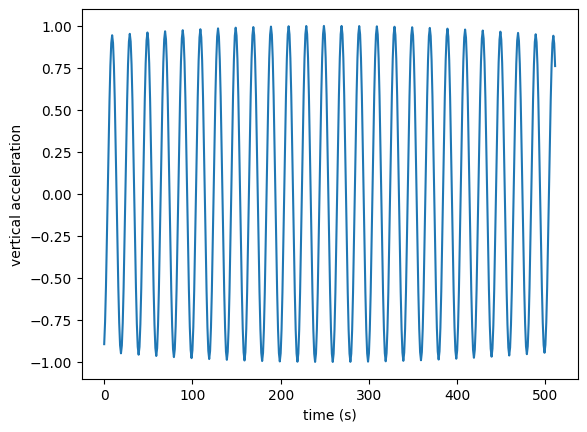

In [15]:
plt.plot()
plt.plot(appliedSegments[1])

plt.xlabel("time (s)")
plt.ylabel("vertical acceleration")
plt.show()

#### Perfrom FFT and normalize to obtain final acceleration spectrum

(0.008469251623288295+0j)
Dominant Frequency: 0.203125
Dominant Frequency Magnitude: 0.7452666338196429


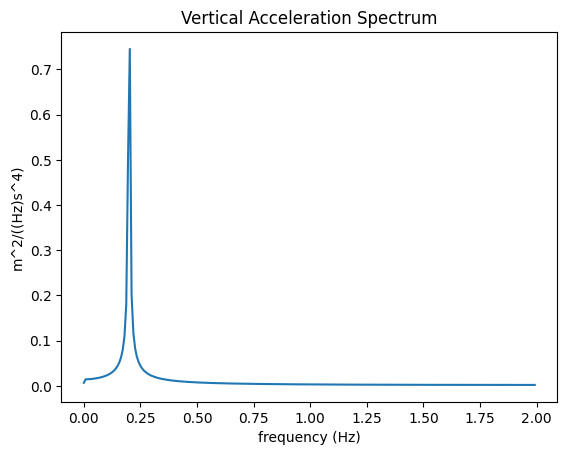

In [16]:
fftSegments = list(map(lambda x: np.abs(np.fft.fft(x)) / len(x), appliedSegments))
complex_segments = list(map(lambda x: np.fft.fft(x) / len(x), appliedSegments))
print(complex_segments[0][0])
# Take only half
fftSegments = list(map(lambda x: x[:len(x)//2], fftSegments))

#average the segments
#fftSegmentAvg = [sum(column)/17 for column in zip(*fftSegments)]
fftSegmentAvg = 2 * np.sum(fftSegments, axis=0) / len(fftSegments)
fftSegmentAvg[0] = fftSegmentAvg[0]/2


# construct frequency domain                  num points in fft
frequency_resolution = (SAMPLING_FREQUENCY / len(fftSegmentAvg))/2 #frequncy interval for each frequency bin (bin width)   -> /2 does it                      
freq_domain = np.linspace(0,(len(fftSegmentAvg)-1)*frequency_resolution, len(fftSegmentAvg)) #x-axis for frequency spectrum

print('Dominant Frequency:', freq_domain[np.argmax(fftSegmentAvg)])
print('Dominant Frequency Magnitude:', np.max(fftSegmentAvg))

plt.plot(freq_domain,fftSegmentAvg)
plt.xlabel('frequency (Hz)')  # Replace 'X-axis Label' with your desired label for the x-axis
plt.ylabel('m^2/((Hz)s^4)')
plt.title('Vertical Acceleration Spectrum')
plt.show()

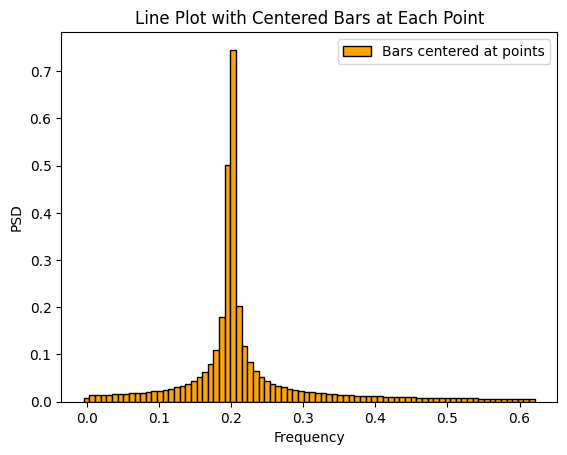

In [17]:
# Adding bars centered at each point
bar_width = freq_domain[1] - freq_domain[0] # Adjust the width to your preference
plt.bar(freq_domain[0:80], fftSegmentAvg[0:80], width=bar_width, color='orange',edgecolor='black', align='center', label='Bars centered at points')

# Add title and labels to the chart
plt.title('Line Plot with Centered Bars at Each Point')
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.legend()

# Show the plot
plt.show()

#### Frequency Domain Filter

0.01645605618006308
0.016240097437542567
0.016024138695022054
0.01580817995250154
0.015592221209981029
0.015376262467460516
0.015160303724940004
0.01494434498241949
0.014728386239898977
0.014512427497378464
0.014296468754857952
0.01408051001233744
0.013864551269816927


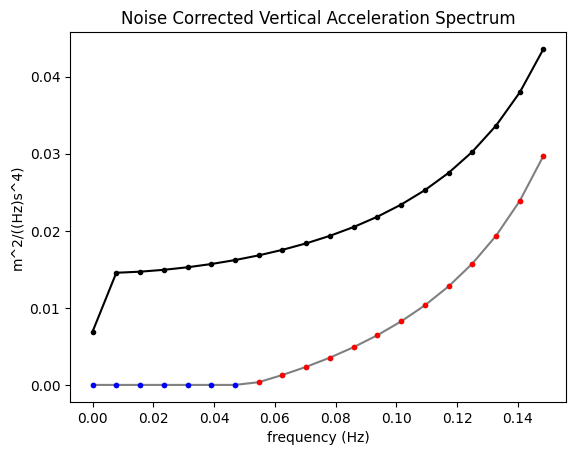

In [18]:
spectral_density = list(fftSegmentAvg) 

def noise(f):
    K = 1.8                                    # bender et al: 20
    G = 1/(len(fftSegmentAvg[2:7]))              #
    F = .65                                     # unkown
    return K*G*sum(fftSegmentAvg[2:7])*(F-f)   # 
    

noise_removed = {"x":[],"y":[]}    
changed_to_zero = {"x":[],"y":[]}

index = 0
while(freq_domain[index] < 0.15):
    nc = noise(freq_domain[index])
    if(freq_domain[index] >= 0.05 and freq_domain[index] >= nc):
        spectral_density[index] -= nc
        print(nc)
        noise_removed["x"].append(freq_domain[index])
        noise_removed["y"].append(spectral_density[index])
    else:
        spectral_density[index] = 0
        changed_to_zero["x"].append(freq_domain[index])
        changed_to_zero["y"].append(spectral_density[index])
        
    index += 1

plt.plot(freq_domain[0:20],fftSegmentAvg[0:20],'.-', color = "black")
plt.plot(freq_domain[0:20],spectral_density[0:20],'.-', color = "gray")
plt.plot(noise_removed["x"],noise_removed["y"],'.', color ='red')
plt.plot(changed_to_zero["x"],changed_to_zero["y"],'.', color ='blue')
plt.xlabel('frequency (Hz)')  # Replace 'X-axis Label' with your desired label for the x-axis
plt.ylabel('m^2/((Hz)s^4)')
plt.title('Noise Corrected Vertical Acceleration Spectrum')
plt.show()

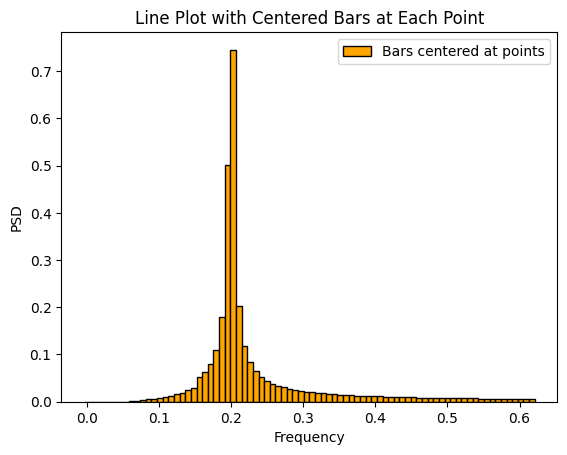

In [19]:
# Adding bars centered at each point
bar_width = freq_domain[1] - freq_domain[0] # Adjust the width to your preference
plt.bar(freq_domain[0:80], spectral_density[0:80], width=bar_width, color='orange',edgecolor='black', align='center', label='Bars centered at points')

# Add title and labels to the chart
plt.title('Line Plot with Centered Bars at Each Point')
plt.xlabel('Frequency')
plt.ylabel('PSD')
plt.legend()

# Show the plot
plt.show()

##### Change Bins

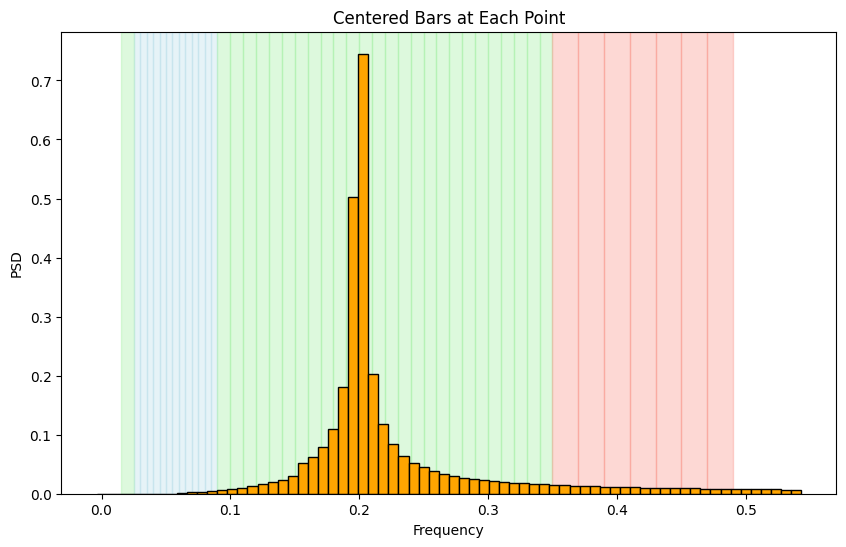

In [20]:
# Adding bars centered at each point
plt.subplots(figsize=(10, 6))
colors = ['lightblue' if x == 0.005 else 'lightgreen' if x == 0.010 else 'salmon' for x in NDBC_BANDWIDTHS]

start = 0.015
for i, (width, color) in enumerate(zip(NDBC_BANDWIDTHS, colors), 0):
    plt.axvspan(start, start+width, color = color, alpha=0.3)
    start += width

bar_width = freq_domain[1] - freq_domain[0] # Adjust the width to your preference
plt.bar(freq_domain[0:70], spectral_density[0:70], width=bar_width, color='orange',edgecolor='black', align='center', label='Bars centered at points')


# Add title and labels to the chart
plt.title('Centered Bars at Each Point')
plt.xlabel('Frequency')
plt.ylabel('PSD')

# Show the plot
plt.show()

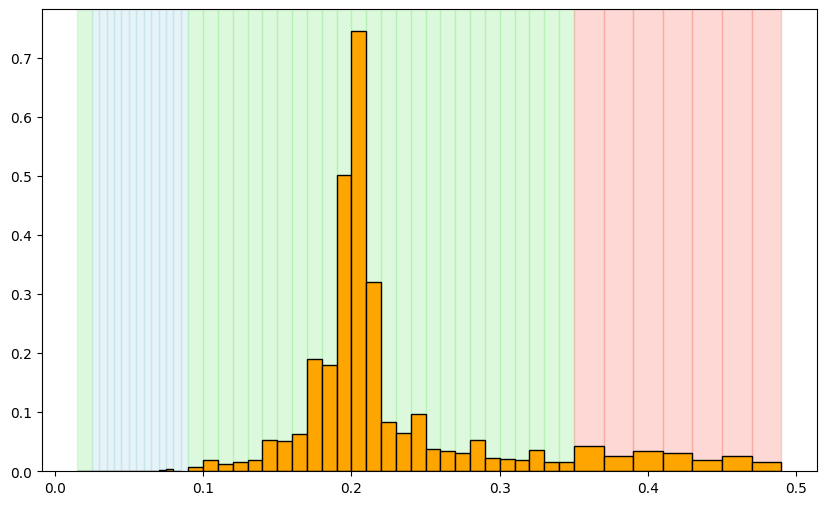

In [21]:
plt.subplots(figsize=(10, 6))
new_bins = []
new_domain = []
## use for loop with nested while loop

count = 0
current_frequency = 0.015
for i in range(len(NDBC_BANDWIDTHS)):
    
    current_frequency += NDBC_BANDWIDTHS[i]
    sum = 0
    while(freq_domain[count] < current_frequency):
        sum += spectral_density[count] 
        count += 1
    new_bins.append(sum)
    new_domain.append(current_frequency-0.5*NDBC_BANDWIDTHS[i])

start = 0.015
for i, (width, color) in enumerate(zip(NDBC_BANDWIDTHS, colors), 0):
    plt.axvspan(start, start+width, color = color, alpha=0.3)
    start += width

plt.bar(new_domain[0:1], new_bins[0:1], width=NDBC_BANDWIDTHS[0], color='orange',edgecolor='black', align='center')
plt.bar(new_domain[1:13], new_bins[1:13], width=NDBC_BANDWIDTHS[1], color='orange',edgecolor='black', align='center')
plt.bar(new_domain[14:40], new_bins[14:40], width=NDBC_BANDWIDTHS[14], color='orange',edgecolor='black', align='center')
plt.bar(new_domain[40:], new_bins[40:], width=NDBC_BANDWIDTHS[41], color='orange',edgecolor='black', align='center')


plt.show()
#remove first bin from calculauation 

256


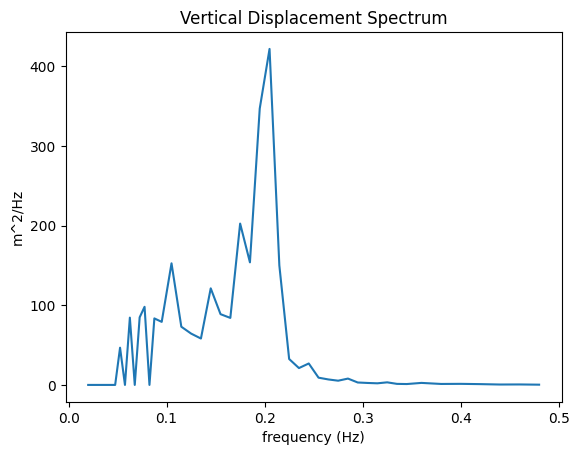

In [22]:
#convert to the displacement spectra by dividing by the frequency to the fourth power.
#midpoint_offset = (freq_domain[1] - freq_domain[0])/2
displacement = list(map(lambda y, x: y/(x**4), new_bins,new_domain))
#print(displacement[0:10])
print(len(freq_domain))
#print(midpoint_offset)

plt.plot(new_domain,displacement)
plt.xlabel('frequency (Hz)')  
plt.ylabel('m^2/Hz')
plt.title('Vertical Displacement Spectrum')
plt.show()

#### Spectral Moments and Wave Statistics

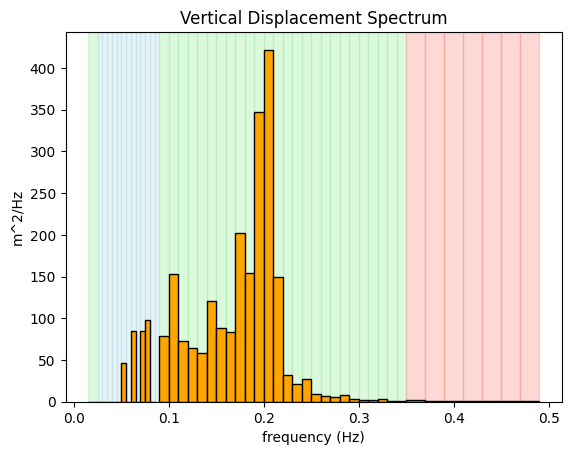

In [23]:
# Adding bars centered at each point
start = 0.015
for i, (width, color) in enumerate(zip(NDBC_BANDWIDTHS, colors), 0):
    plt.axvspan(start, start+width, color = color, alpha=0.3)
    start += width

plt.bar(new_domain[0:1], displacement[0:1], width=NDBC_BANDWIDTHS[0], color='orange',edgecolor='black', align='center')
plt.bar(new_domain[1:13], displacement[1:13], width=NDBC_BANDWIDTHS[1], color='orange',edgecolor='black', align='center')
plt.bar(new_domain[14:40], displacement[14:40], width=NDBC_BANDWIDTHS[14], color='orange',edgecolor='black', align='center')
plt.bar(new_domain[40:], displacement[40:], width=NDBC_BANDWIDTHS[41], color='orange',edgecolor='black', align='center')

plt.xlabel('frequency (Hz)')  
plt.ylabel('m^2/Hz')
plt.title('Vertical Displacement Spectrum')
plt.show()

In [25]:
def get_spectral_moment(num: int):
    return sum(list(map(lambda x, y: (y**num) * x * (NDBC_BANDWIDTHS[new_domain.index(y)]),displacement, new_domain)))

significant_wave_height = 4 * math.sqrt(get_spectral_moment(0))
mean_periord = get_spectral_moment(0)/get_spectral_moment(1)
peak_periord = 
print(significant_wave_height)
print(mean_periord)